In [23]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('../Data/merged_data.csv')
print(df.head())
# Chuyển cột Date thành kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])



         Date  Close Stock Price  Close Currency Rate  \
0  2019-11-11         240.710312             1.102244   
1  2019-11-12         241.446991             1.103546   
2  2019-11-13         241.446991             1.101237   
3  2019-11-14         240.802383             1.101322   
4  2019-11-15         241.047948             1.102050   

   Total_Sales_EUR_Million    EPS  
0              7587.798913  3.565  
1              7580.689130  3.570  
2              7573.579348  3.575  
3              7566.469565  3.580  
4              7559.359783  3.585  


In [25]:
# Feature Engineering ===
print("\n=== Feature Engineering ===")

# Tạo lag features cho các cột
columns_to_lag = ['Close Stock Price', 'Close Currency Rate', 'Total_Sales_EUR_Million', 'EPS']
look_back = 10 # Số ngày trễ

for column in columns_to_lag:
    for lag in range(1, look_back + 1):
        df[f'{column}_Lag_{lag}'] = df[column].shift(lag)

# Loại bỏ các hàng có giá trị NaN do tạo lag features
df.dropna(inplace=True)

# Chọn các cột đặc trưng (features) và mục tiêu (target)
feature_columns = [col for col in df.columns if 'Lag' in col]
X = df[feature_columns]
y = df['Close Stock Price']

print("Sample data with lag features:")
print(df.head())


=== Feature Engineering ===
Sample data with lag features:
         Date  Close Stock Price  Close Currency Rate  \
10 2019-11-21         235.185211             1.107886   
11 2019-11-22         235.185211             1.106586   
12 2019-11-23         235.185211             1.105143   
13 2019-11-24         235.185211             1.103700   
14 2019-11-25         236.934830             1.102256   

    Total_Sales_EUR_Million    EPS  Close Stock Price_Lag_1  \
10              7516.701087  3.615               235.277283   
11              7509.591304  3.620               235.185211   
12              7502.481522  3.625               235.185211   
13              7495.371739  3.630               235.185211   
14              7488.261957  3.635               235.185211   

    Close Stock Price_Lag_2  Close Stock Price_Lag_3  Close Stock Price_Lag_4  \
10               238.131927               240.157776               241.539078   
11               235.277283               238.131927    

In [26]:
# Train-Test Split ===
print("\n=== Train-Test Split ===")

# Chia tập train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")



=== Train-Test Split ===
Training set size: 1424, Test set size: 356


In [27]:
#  Decision Tree Regressor ===
print("\n===  Decision Tree Regressor ===")

# Khởi tạo và huấn luyện mô hình
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = decision_tree_model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Evaluation Metrics ===")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


===  Decision Tree Regressor ===
=== Evaluation Metrics ===
Mean Squared Error (MSE): 179.0137410995577
R² Score: 0.7647925671401897


In [28]:
# Lấy giá trị cuối cùng của các đặc trưng khác
last_currency_rate = df['Close Currency Rate'].iloc[-1]
last_total_sales = df['Total_Sales_EUR_Million'].iloc[-1]
last_eps = df['EPS'].iloc[-1]

# Lấy dữ liệu cuối cùng để dự đoán 60 ngày tiếp theo
future_predictions = []
current_input = X.iloc[-1].values  # Sử dụng giá trị cuối cùng của tập dữ liệu

for _ in range(60):
    # Dự đoán giá trị tiếp theo
    next_prediction = decision_tree_model.predict([current_input])[0]
    future_predictions.append(next_prediction)

    # Cập nhật đầu vào (shift) cho dự đoán tiếp theo
    current_input = np.append(current_input[len(columns_to_lag):], [
        next_prediction,  # Giá trị dự đoán mới
        last_currency_rate,  # Giữ nguyên tỷ giá hối đoái
        last_total_sales,   # Giữ nguyên doanh số
        last_eps            # Giữ nguyên EPS
    ])

# Tạo DataFrame cho các ngày dự đoán tương lai
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=61, freq='D')[1:]
future_df = pd.DataFrame({'Date': future_dates})

# Sử dụng moving average để làm mượt dự đoán
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Làm mượt dự đoán
smoothed_predictions = moving_average(future_predictions, window_size=5)

# Cập nhật lại ngày tương ứng với dự đoán mượt
smoothed_dates = future_df['Date'][:len(smoothed_predictions)]


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but

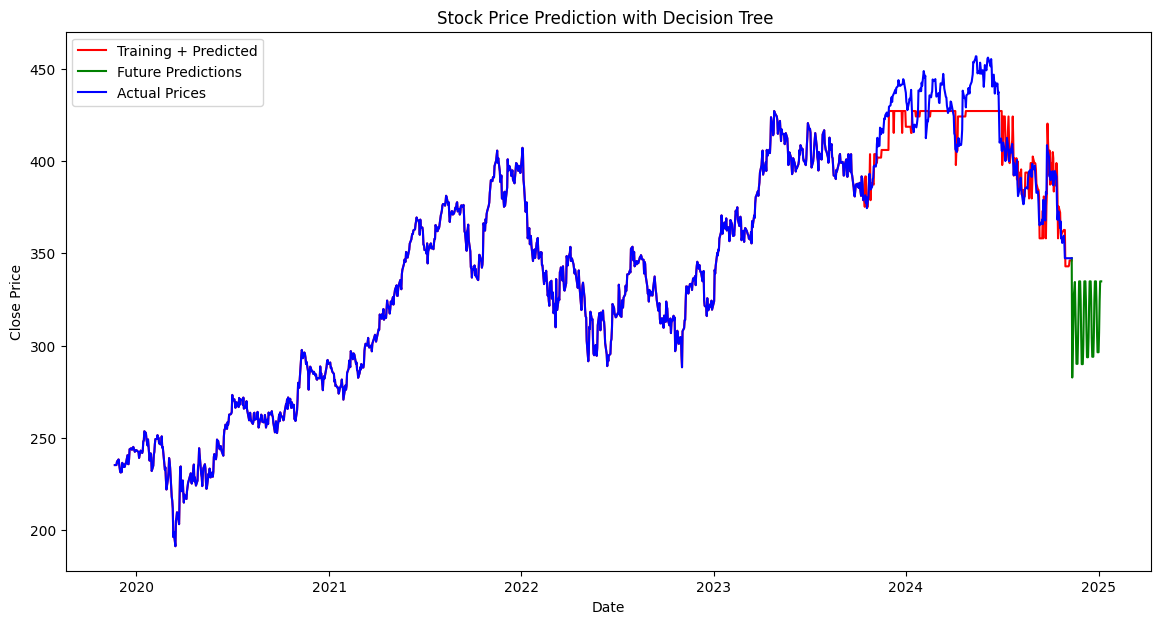

In [29]:
# Dự đoán lại giá trên toàn bộ tập dữ liệu (training + test) để hiển thị giai đoạn dự đoán trên dữ liệu huấn luyện và kiểm tra
all_predictions = decision_tree_model.predict(X)

# Thêm giá trị thực tế cuối cùng vào đầu đường dự đoán tương lai
smoothed_predictions = np.insert(smoothed_predictions, 0, df['Close Stock Price'].iloc[-1])
smoothed_dates = pd.concat([pd.Series([df['Date'].iloc[-1]]), smoothed_dates]).reset_index(drop=True)

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# 1. Đường màu đỏ: Giá thực tế + dự đoán trên tập training và test
plt.plot(df['Date'], all_predictions, label='Training + Predicted', color='red')

# 2. Đường màu xanh: Giá dự đoán tương lai đã làm mượt
plt.plot(smoothed_dates, smoothed_predictions, label='Future Predictions', color='green')

# 3. Đường thực tế (chỉ hiển thị cho tham khảo)
plt.plot(df['Date'], df['Close Stock Price'], label='Actual Prices', color='blue')

# Định dạng biểu đồ
plt.legend()
plt.title("Stock Price Prediction with Decision Tree ")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


In [30]:
from sklearn.ensemble import RandomForestRegressor

#  Random Forest Regressor ===
print("\n=== Random Forest Regressor ===")

# Khởi tạo và huấn luyện mô hình Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = random_forest_model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Evaluation Metrics ===")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")



=== Random Forest Regressor ===
=== Evaluation Metrics ===
Mean Squared Error (MSE): 190.310699539413
R² Score: 0.7499494127686793


In [31]:
# Lấy giá trị cuối cùng của các đặc trưng khác
last_currency_rate = df['Close Currency Rate'].iloc[-1]
last_total_sales = df['Total_Sales_EUR_Million'].iloc[-1]
last_eps = df['EPS'].iloc[-1]

# Lấy dữ liệu cuối cùng để dự đoán 60 ngày tiếp theo
future_predictions = []
current_input = X.iloc[-1].values  # Sử dụng giá trị cuối cùng của tập dữ liệu

for _ in range(60):
    # Dự đoán giá trị tiếp theo bằng Random Forest
    next_prediction = random_forest_model.predict([current_input])[0]
    future_predictions.append(next_prediction)

    # Cập nhật đầu vào (shift) cho dự đoán tiếp theo
    current_input = np.append(current_input[len(columns_to_lag):], [
        next_prediction,  # Giá trị dự đoán mới
        last_currency_rate,  # Giữ nguyên tỷ giá hối đoái
        last_total_sales,   # Giữ nguyên doanh số
        last_eps            # Giữ nguyên EPS
    ])

# Tạo DataFrame cho các ngày dự đoán tương lai
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=61, freq='D')[1:]
future_df = pd.DataFrame({'Date': future_dates})

# Sử dụng moving average để làm mượt dự đoán
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Làm mượt dự đoán
smoothed_predictions = moving_average(future_predictions, window_size=5)

# Cập nhật lại ngày tương ứng với dự đoán mượt
smoothed_dates = future_df['Date'][:len(smoothed_predictions)]


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but

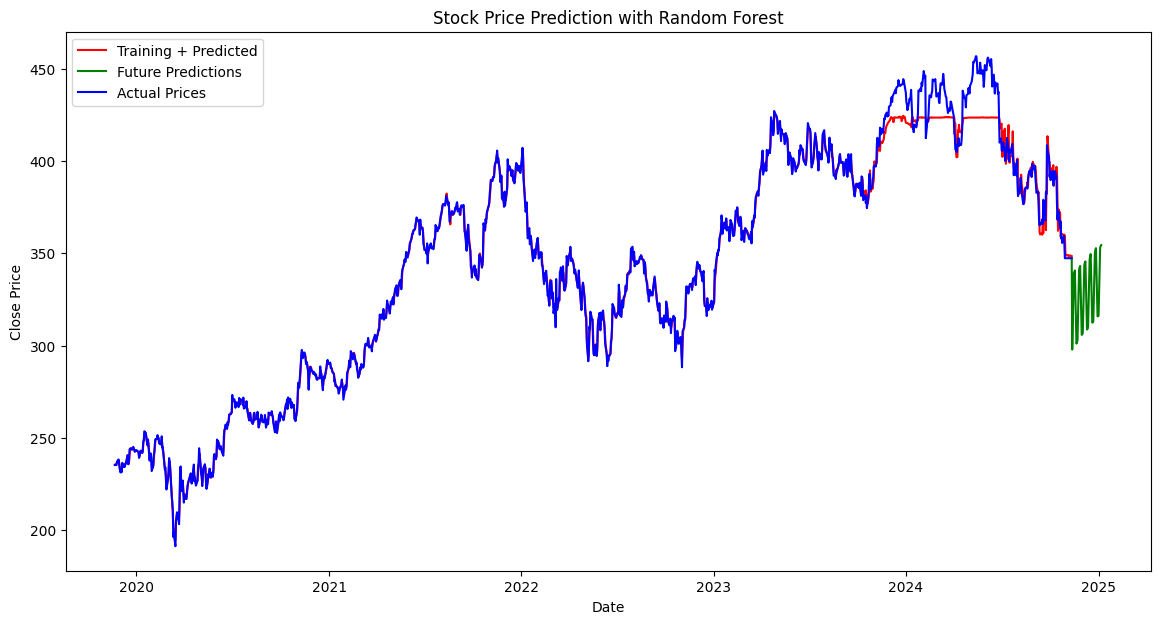

In [32]:
# Dự đoán lại giá trên toàn bộ tập dữ liệu (training + test)
all_predictions = random_forest_model.predict(X)

# Thêm giá trị thực tế cuối cùng vào đầu đường dự đoán tương lai
smoothed_predictions = np.insert(smoothed_predictions, 0, df['Close Stock Price'].iloc[-1])
smoothed_dates = pd.concat([pd.Series([df['Date'].iloc[-1]]), smoothed_dates]).reset_index(drop=True)

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# 1. Đường màu đỏ: Giá thực tế + dự đoán trên tập training và test
plt.plot(df['Date'], all_predictions, label='Training + Predicted', color='red')

# 2. Đường màu xanh: Giá dự đoán tương lai đã làm mượt
plt.plot(smoothed_dates, smoothed_predictions, label='Future Predictions', color='green')

# 3. Đường thực tế (chỉ hiển thị cho tham khảo)
plt.plot(df['Date'], df['Close Stock Price'], label='Actual Prices', color='blue')

# Định dạng biểu đồ
plt.legend()
plt.title("Stock Price Prediction with Random Forest")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()
